# Event Store Healthcare Demo


This Python notebook performs ECG analysis to detect QRS complexes and their duration. As the data is bening analyzed, waveform graphs and numerical metrics are displayed to monitor the healthcare metrics of the patient.

The data contains recordings of multiple physiologic signals ("waveforms") and time series of vital signs ("numerics") collected from bedside patient monitors.

This notebook runs in a **Python 3.6** with Spark 2.1.


### Electrocardiogram (ECG) and QRS Complex

A normal ECG heart signal consists of a periodic pattern. Different points in a signal period of this pattern are labeled as P,Q,R,S and T.

The **QRS complex** corresponds to the depolarization of the right and left verticles og the human heart. If they are working efficiently, the **QRS complex** is 0.08-0.12 seconds in duration, which can be shorter for kids.


<table>
<tr>
    
<td> <img src="https://www.aedsuperstore.com/resources/wp-content/uploads/sites/4/2016/03/1456943145_image5.gif"
          alt="ECG" style="width: 500px; height: 350px;"/> </td>
          
<td> <img src="http://ib.bioninja.com.au/_Media/ecg_med.jpeg" alt="ECG" style="width: 500px; height: 350px;"/> </td>
</tr>
</table>

### QRS Detection

Accurate QRS detection is an important first step for the analysis of heart rate variability. Algorithms based on the differentiated ECG are computationally efficient and hence ideal for real-time analysis of large datasets. This notebook uses the Pan-Tompkins algorithm for QRS detection. The Pan-Tompkins algorithm is one of the most popular single-lead first-derivative-based QRS detection methods.

![Live Stream Demo](https://github.com/mlhubca/lab/blob/master/eventstore/animation.gif?raw=true)


## Table of contents

This notebook is divided into the following parts:

[Part 1: Setup](#setup)<br>
[Part 2: Loading Data](#loading)<br>
[Part 3: Defining Functions](#defining)<br>
[Part 4: Analyzing Data](#analyzing)<br>
[Part 5: Visualizing Results](#visualizing)<br>
[Part 6: Summary](#summary)<br>

<a id="setup"></a>
## Part 1: Setup

### 1.1 Import Python libraries

In [1]:
import os
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from biosppy.signals import ecg

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import display, HTML
from plotly import tools
import plotly.graph_objs as go 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

init_notebook_mode(connected=True)

### 1.2 Enable full length of cells in notebook

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<a id="loading"></a>
## Part 2: Loading Data

Load the data asset and show a snapshot of the data. The data contains recordings of multiple physiologic signals ("waveforms") and time series of vital signs ("numerics") collected from bedside patient monitors. 

Waveforms include:

- One or more ECG signals
- Fingertip photoplethysmogram PPG signals (PLETH)
- Respiration

Numerics typically include:

- Systolic and diastolic blood pressure (ABP)
- Heart rate
- Pulse
- SpO2

In [3]:
df_data = pd.read_csv('../data/raw-20190110_025151.csv')
df_data.head()

,patient,ABP Systolic,ABP Diastolic,ECG Lead II,ECG Lead V,Pleth,Resp,HR,PULSE,SpO2,timestamp
0,patient-2,155.0,91.0,-36.0,207.0,717.0,263.0,73.0,74.0,80.0,31.968
1,patient-5,155.0,91.0,-36.0,207.0,717.0,263.0,73.0,74.0,80.0,31.968
2,patient-4,102.0,52.0,2232.0,644.0,2050.0,1427.0,83.0,81.0,98.0,31.968
3,patient-3,59.0,81.0,1187.0,1270.0,2851.0,-2.0,99.0,99.0,94.0,32.128
4,patient-2,155.0,91.0,-38.0,207.0,693.0,263.0,73.0,74.0,80.0,31.976


<a id="defining"></a>
## Part 3: Defining Functions

### 3.1 Define QRS complex detection functions

The following functions are used to detect the Q,R,S waves in ECG Lead II using Pan-Tompkins algorithm.

In [4]:
def r_peaks(wave,s_rate=125):
    """
    Helper function used to detect r peaks in QRS complex using Pan-Tompkins algorithm.
    -----------
    Parameters:
    w - ECG Lead II signal
    s_rate - sampling rate i.e. number of observations per second
    -----------
    Returns:
    rpeaks - a list containing the r peaks indices
    """
    output = ecg.ecg(signal=wave, sampling_rate=s_rate, show=False)
    rpeaks = list(output['rpeaks'])
    
    return rpeaks

def metrics_note(df):
    """
    This function summarizes the numeric data i.e 'ABP Systolic', 'ABP Diastolic', 'HR', 'PULSE', 'SpO2' of each patient.
    -----------
    Parameters:
    df - original dataframe
    -----------
    Returns:
    df - dataframe, which includes summary column note
    """
    metrics = ['ABP Systolic', 'ABP Diastolic', 'HR', 'PULSE', 'SpO2']
    df[metrics]= df[metrics].astype(int)
    df['note'] = 'ABP:' + df[metrics[0]].astype(str) +"/" + df[metrics[1]].astype(str) + ", HR:"+ df[metrics[2]].astype(str)+ ", PULSE:"+ df[metrics[3]].astype(str)+ ", SpO2:"+ df[metrics[4]].astype(str)
    
    return df

def find_peaks(wave):
    """
    Locate peaks based on derivative.
    -----------
    Parameters:
    wave - list or array signal
    -----------
    Returns:
    peaks : an array containing the peak indices
    """
    derivative = np.gradient(wave, 2)
    peaks = np.where(np.diff(np.sign(derivative)))[0]
    
    return peaks

def find_closest_in_list(number, array):
    """
    Find the closest number in the array from x.
    -----------
    Parameters:
    number - float
    array - the list to look in
    -----------
    Returns:
    closest : int; the closest number in the array
    """
    closest = min(array, key=lambda x:abs(x-number))
    
    return closest


In [5]:
def ecg_wave_detector(signal, rpeaks):
    """
    Returns the localization of the P, Q, S, T waves.
    -----------
    Parameters:
    signal - list or ndarray, ECG signal (preferably filtered)
    rpeaks - list or ndarray, r peaks indices
    -----------
    Returns:
    ecg_waves - dict; contains wave peaks location indices
    >>> ecg_waves["P_Waves"]
        ecg_waves["Q_Waves_Onsets"], ecg_waves["Q_Waves"]
        ecg_waves["S_Waves"]
        ecg_waves["T_Waves_Onsets"], ecg_waves["T_Waves"], ecg_waves["T_Waves_Ends"]
  
    """
    q_waves = []
    p_waves = []
    q_waves_starts = []
    s_waves = []
    t_waves = []
    t_waves_starts = []
    t_waves_ends = []
    qrs = []
    
    for index, rpeak in enumerate(rpeaks[:]):
        comp = []
        comp.append(rpeak-4)
        comp.append(rpeak)
        comp.append(rpeak+4)
        try:
            epoch_before = np.array(signal)[int(rpeaks[index-1]):int(rpeak)]
            epoch_before = epoch_before[int(len(epoch_before)/2):len(epoch_before)]
            epoch_before = list(reversed(epoch_before))

            q_wave_index = np.min(find_peaks(epoch_before))
            q_wave = rpeak - q_wave_index
            p_wave_index = q_wave_index + np.argmax(epoch_before[q_wave_index:])
            p_wave = rpeak - p_wave_index

            inter_pq = epoch_before[q_wave_index:p_wave_index]
            inter_pq_derivative = np.gradient(inter_pq, 2)
            q_start_index = find_closest_in_list(len(inter_pq_derivative)/2, find_peaks(inter_pq_derivative))
            q_start = q_wave - q_start_index

            q_waves.append(q_wave)
            p_waves.append(p_wave)
            q_waves_starts.append(q_start)
            
            comp.append(q_start)
            comp.append(q_wave)
            
        except ValueError:
            pass
        except IndexError:
            pass

        try:
            epoch_after = np.array(signal)[int(rpeak):int(rpeaks[index+1])]
            epoch_after = epoch_after[0:int(len(epoch_after)/2)]

            s_wave_index = np.min(find_peaks(epoch_after))
            s_wave = rpeak + s_wave_index
            t_wave_index = s_wave_index + np.argmax(epoch_after[s_wave_index:])
            t_wave = rpeak + t_wave_index

            inter_st = epoch_after[s_wave_index:t_wave_index]
            inter_st_derivative = np.gradient(inter_st, 2)
            t_start_index = find_closest_in_list(len(inter_st_derivative)/2, find_peaks(inter_st_derivative))
            t_start = s_wave + t_start_index
            t_end = np.min(find_peaks(epoch_after[t_wave_index:]))
            t_end = t_wave + t_end

            s_waves.append(s_wave)
            t_waves.append(t_wave)
            t_waves_starts.append(t_start)
            t_waves_ends.append(t_end)
            
            comp.append(s_wave)
           
        except ValueError:
            pass
        except IndexError:
            pass
        
        qrs.append(sorted(comp))

    ecg_waves = {"P_Waves": p_waves,
                 "Q_Waves": q_waves,
                 "R_Waves": rpeaks,
                 "S_Waves": s_waves,
                 "T_Waves": t_waves,
                 "Q_Waves_Starts": q_waves_starts,
                 "T_Waves_Starts": t_waves_starts,
                 "T_Waves_Ends": t_waves_ends}
    return qrs, ecg_waves

In [6]:
def qrs_complex(patient, data):
    """
    This function detects the QRS complex in patient's ECG.
    -----------
    Parameters:
    patient - str, patient id i.e. patient-1
    data - original dataframe
    -----------
    Returns:
    patient_qrs_data - dataframe that includes qrs complex annotations
    
    """
    col = 'ECG Lead II'
    waves = ["R_Waves", "Q_Waves_Starts", "S_Waves", "T_Waves_Starts"]
    
    patient_data = data.copy()[data.patient == patient].reset_index(drop=True)
    length = len(patient_data)
    
    series = patient_data.copy()[col]
    rpeaks_indices = r_peaks(series)
    qrs_indices, waves_indices = ecg_wave_detector(series,rpeaks_indices)
    
    for w in waves:
        patient_data[w] = np.arange(0,length)
        patient_data[w] = patient_data[w].apply(lambda i: 1 if i in waves_indices[w] else 0)
        patient_data[w] = patient_data[w]*patient_data[col]
        
    return qrs_indices, patient_data

### 3.2 Define visualization functions

The functions use **matplotlib** dynamic plotting and interactive plotting library **plotly**.

In [7]:
def plotting(df,qrs):
    
    """
    df - patient data
    qrs - QRS complex indices
    
    This function plots patient data along with the rpeaks and QRS complexes.
    
    """
    
    cols = ['ECG Lead II','ECG Lead V','Pleth', 'Resp']
    waves = ["Q_Waves_Starts","R_Waves", "S_Waves", "T_Waves_Starts"]
    max_ecg = [df['ECG Lead II'].max()]
    ave_qrs_duration = np.round(np.mean([(l[-1]-l[0])/125 for l in patient_qrs]),3)
    
    fig = tools.make_subplots(rows=len(cols)+1, cols=1, subplot_titles =(['','ECG Lead II', 'ECG Lead V','Pleth', 'Resp']),print_grid=False)
    
    # Creating Traces
    ## Metrics Trace
    metrics = ['ABP Systolic', 'ABP Diastolic', 'HR', 'PULSE', 'SpO2']
    trace = go.Scatter(x=[1, 2, 3, 4, 5], y=[2, 2, 2, 2, 2],
                       text=['<b>ABP<br>{}/{}</b>'.format(int(df[metrics[0]].median()),int(df[metrics[1]].median())), 
                             '<b>HR<br>{}</b>'.format(int(df[metrics[2]].median())), 
                             '<b>PULSE<br>{}</b>'.format(int(df[metrics[3]].median())),
                             '<b>SpO2<br>{}</b>'.format(int(df[metrics[4]].median())),
                             '<b>QRS<br>DURATION<br>{}</b>'.format(ave_qrs_duration)],
                       mode='markers+text',
                       marker=dict(color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)',  'rgb(44, 160, 101)', 'rgb(255, 65, 54)','rgb(211,211,211)'],size=[100, 100, 100, 100, 100]),
                       hoverinfo ='none',showlegend=False)
    
    fig.append_trace(trace, 1, 1)
    
    ## Waveforms Traces
    for i,c in enumerate(cols):
        trace0 = go.Scatter(x = df.index,y = df[c], mode = 'lines', name = c, text=c,showlegend=False)
        fig.append_trace(trace0, i+2, 1)
        
    ## R-peaks    
    trace1 = go.Scatter(x = df.index[df[waves[1]]!= 0],y = df.loc[df[waves[1]]!= 0, waves[1]], 
                        mode = 'markers', marker = dict(color = 'rgb(231, 99, 250)', size = 3,line = dict(color = 'rgb(231, 99, 250)', width = 8)),
                        name = 'R peaks',text='R peaks',showlegend=True)
    fig.append_trace(trace1, 2, 1)
    
    ## QRS Complex
    for j in qrs:
        trace2 = go.Scatter(x = j, y = max_ecg*len(j), mode='none', fill='tozeroy', fillcolor = 'rgba(17, 157, 255,0.5)',showlegend=False,text = 'QRS Complex')
        fig.append_trace(trace2, 2,  1)
    
        
    fig['layout'].update(height=1000,width=1500, title = "Patient ID: {}".format("".join(df.patient.unique())))
    fig['layout']['xaxis1'].update(showgrid=False,showticklabels=False)
    fig['layout']['yaxis1'].update(showgrid=False,showticklabels=False)
    iplot(fig, filename='stacked-subplots')

In [8]:
def plt_dynamic(x, y, ax, c='b'):
    """
    This function plots waveforms.
    
    """
    ax.plot(x, y, color=c, lw = 2)
    fig.canvas.draw()
    
def plt_dynamic_rpeaks(x, y, ax):
    """
    This function plots R peaks.
    
    """
    ax.scatter(x, y, color='r', s = 200, marker='h', alpha=1)
    fig.canvas.draw()
    
def plt_dynamic_scatter(txt, ax, i):
    """
    This function plots numerics.
    
    """
    num_name = ["ABP", "HR", "PULSE", "SpO2","QRS \n DURATION"]
    bubble_size = [17000, 17000, 17000, 17000, 17000]
    bubble_y = [3, 3, 3, 3, 3]
    bubble_x = [200, 600, 1000, 1400, 1800]
    text = txt
    ann_list = []
    
    ax.scatter(bubble_x,bubble_y, s=bubble_size,marker='o', c=['skyblue','orange','lightgreen','coral','lightgrey'])
    
    # Labeling each bubble
    for n,c,r,t in zip(num_name,bubble_y,bubble_x,text):
        ann_one = ax.annotate("{}".format(t),xy=(r, c), ha="center", va="top",size=20,fontweight='bold') # numbers
        ann_list.append(ann_one)
        ann_two = ax.annotate(n ,xy=(r, c), xytext=(0,np.sqrt(c)/2.+5), textcoords="offset points", ha="center", va="bottom",size=17,fontweight='bold') #text
    fig.canvas.draw()    
    time.sleep(.2)
        
    # Removing annotations after drawing
    for ann in ann_list:
        ann.remove()

def plt_area_qrs(x, y, ax):
    """
    This function plots QRS complexes.
    
    """
    ax.fill_between(x,y*len(x),color="skyblue", alpha=0.7)
    fig.canvas.draw()

<a id="analyzing"></a>
## Part 4: Analyzing Data

Before running the demo run all the cells above by first selecting this cell, then clicking <b>Cell</b> --> Run All Above.

The cell below enables you to select the patient, whose health data you want to monitor and analyze. Uncomment the code by removing the hashtag and run the cells below:

In [9]:
p_id ='patient-3'

patient_qrs, patient_df = qrs_complex(p_id,df_data)
patient_df = metrics_note(patient_df)
patient_df.head()

,patient,ABP Systolic,ABP Diastolic,ECG Lead II,ECG Lead V,Pleth,Resp,HR,PULSE,SpO2,timestamp,R_Waves,Q_Waves_Starts,S_Waves,T_Waves_Starts,note
0,patient-3,59,81,1187.0,1270.0,2851.0,-2.0,99,99,94,32.128,0.0,0.0,0.0,0.0,"ABP:59/81, HR:99, PULSE:99, SpO2:94"
1,patient-3,59,81,1197.0,1290.0,2776.0,-2.0,99,99,94,32.136,0.0,0.0,0.0,0.0,"ABP:59/81, HR:99, PULSE:99, SpO2:94"
2,patient-3,59,81,1218.0,1300.0,2690.0,-2.0,99,99,94,32.144,0.0,0.0,0.0,0.0,"ABP:59/81, HR:99, PULSE:99, SpO2:94"
3,patient-3,59,81,1218.0,1311.0,2594.0,-2.0,99,99,94,32.152,0.0,0.0,0.0,0.0,"ABP:59/81, HR:99, PULSE:99, SpO2:94"
4,patient-3,59,81,1238.0,1331.0,2493.0,-2.0,99,99,94,32.160,0.0,0.0,0.0,0.0,"ABP:59/81, HR:99, PULSE:99, SpO2:94"


<a id="visualizing"></a>
## Part 5: Visualizing Results
### 5.1 Visualize results in a dynamic plot

<IPython.core.display.Javascript object>


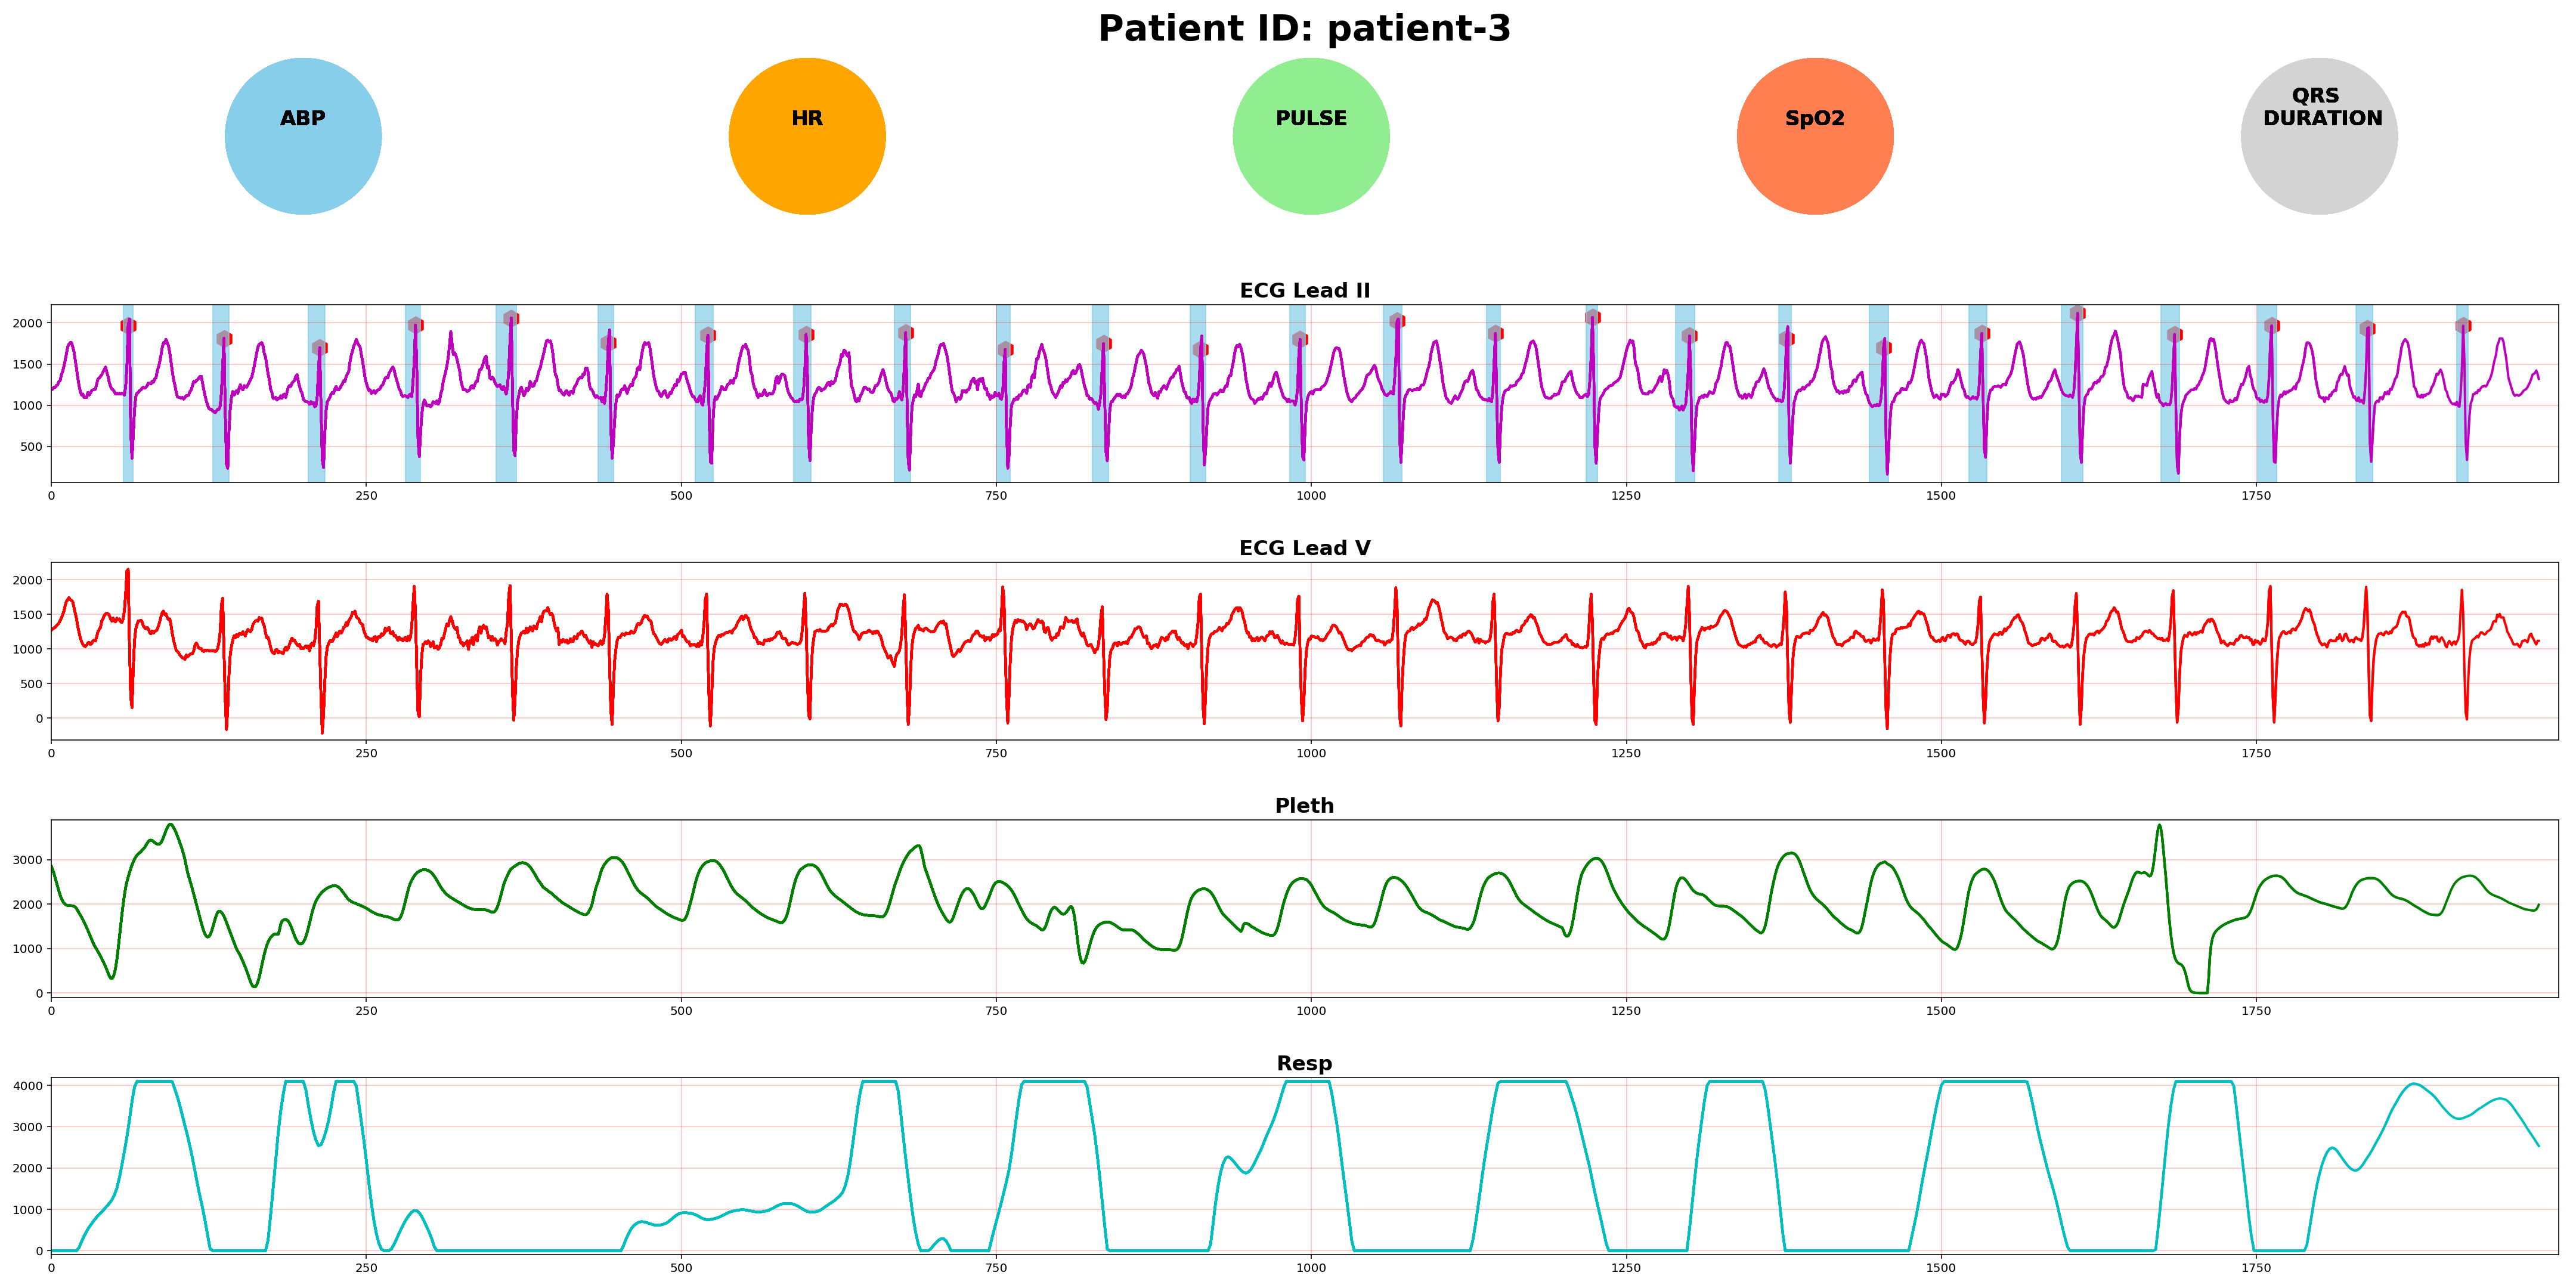

In [10]:
##### Lists to store the data as it is collected

## Waveforms
xs, ecg_ys_one = [], []
xs, ecg_ys_two = [],[]
xs, pleth_ys = [],[]
xs, resp_ys = [],[]

## Numerics
nums = []

## QRS Durations
qrs_durations = [((l[-1]-l[0])/125) for l in patient_qrs]

## Maximum  ECG
max_ecg = [patient_df['ECG Lead II'].max()+100]

## Data and R peaks Length
df_len = len(patient_df)
r_len = len(patient_qrs)

%matplotlib notebook

# Defining the parameters of plot  
fig = plt.figure(figsize=(30,15))
b = 100

## Sublot one for numerics: ABP, HR, PULSE, SpO2, QRS DURATION
ax = fig.add_subplot(511)
ax.set_xlim(0,len(patient_df)) ; ax.set_ylim(0,6)
ax.set_title('Patient ID: {}'.format(p_id), fontdict={'fontsize': 'xx-large', 'fontweight': 'bold','size':30})
ax.axis('off')

## Sublot two for waveforms: ECG Lead II
ax1 = fig.add_subplot(512)
ax1.set_xlim(0,len(patient_df)) ; ax1.set_ylim(np.min(patient_df['ECG Lead II'])-b,np.max(patient_df['ECG Lead II'])+b)
ax1.set_title('ECG Lead II', fontdict={'fontsize': 'xx-large', 'fontweight': 'bold'})
ax1.grid(color='r', linestyle='-', linewidth=0.2)

## Sublot three for waveforms: ECG Lead V
ax2 = fig.add_subplot(513)
ax2.set_xlim(0,len(patient_df)) ; ax2.set_ylim(np.min(patient_df['ECG Lead V'])-b,np.max(patient_df['ECG Lead V'])+b)
ax2.set_title('ECG Lead V', fontdict={'fontsize': 'xx-large', 'fontweight': 'bold'})
ax2.grid(color='r', linestyle='-', linewidth=0.2)

## Sublot four for waveforms: Resp
ax3 = fig.add_subplot(514)
ax3.set_xlim(0,len(patient_df)) ; ax3.set_ylim(np.min(patient_df['Pleth'])-b,np.max(patient_df['Pleth'])+b)
ax3.set_title('Pleth', fontdict={'fontsize': 'xx-large', 'fontweight': 'bold'})
ax3.grid(color='r', linestyle='-', linewidth=0.2)

## Sublot five for waveforms: Pleth
ax4 = fig.add_subplot(515)
ax4.set_xlim(0,len(patient_df)) ; ax4.set_ylim(np.min(patient_df['Resp'])-b,np.max(patient_df['Resp'])+b)
ax4.set_title('Resp', fontdict={'fontsize': 'xx-large', 'fontweight': 'bold'})
ax4.grid(color='r', linestyle='-', linewidth=0.2)

fig.tight_layout(h_pad=3)

# This is a loop for which you want to plot the dynamic updates

## Data is collected with frequency approximately 125 points per second due to format conversion exact frequency is unknown
step = int(df_len/r_len)

## For Loop
for i, j in zip(range(0,df_len,step), range(0,r_len)):
    ### Updating waveforms 
    ecg_y_one = patient_df.loc[i:i+step-1,'ECG Lead II']
    ecg_y_two = patient_df.loc[i:i+step-1,'ECG Lead V']
    pleth_y = patient_df.loc[i:i+step-1,'Pleth']
    resp_y = patient_df.loc[i:i+step-1,'Resp']
    
    xs.extend(range(i,i+step))
    ecg_ys_one.extend(ecg_y_one)
    ecg_ys_two.extend(ecg_y_two)
    pleth_ys.extend(pleth_y)
    resp_ys.extend(resp_y)
    
    ### Updating numerics
    abp = str(patient_df.loc[i,'ABP Systolic']) + '/' + str(patient_df.loc[i,'ABP Diastolic'])
    hr = str(patient_df.loc[i,'HR'])
    pulse = str(patient_df.loc[i,'PULSE'])
    spo2 = str(patient_df.loc[i,'SpO2'])
    qrs_duration = str(qrs_durations[j])
      
    nums = [abp,hr,pulse,spo2,qrs_duration]
    
    ### Updating R peaks
    ecg_y_one_r = patient_df[patient_df['R_Waves'] != 0].loc[i:i+step-1,'R_Waves']
    ecg_x_one_r = list(patient_df[patient_df['R_Waves'] != 0].loc[i:i+step-1,'R_Waves'].index)
    
    ### Plotting
    plt_dynamic_scatter(nums,ax=ax,i=i)  
    plt_dynamic(xs[:len(patient_df)], ecg_ys_one, ax1,c = 'm')
    plt_dynamic_rpeaks(ecg_x_one_r,ecg_y_one_r,ax1)
    plt_area_qrs(patient_qrs[j],max_ecg,ax1)   
    plt_dynamic(xs[:len(patient_df)], ecg_ys_two, ax2,c = 'r')   
    plt_dynamic(xs[:len(patient_df)], pleth_ys, ax3,c ='g')   
    plt_dynamic(xs[:len(patient_df)], resp_ys, ax4,c ='c')
    
    time.sleep(.1)

### 5.2 Visualize resutls in an interactive plot

In [11]:
plotting(patient_df,patient_qrs)

<a id="summary"></a>
## Part 6: Summary

This notebook is **NOT INTENDED** for medical diagnosis.

* Safura Suleymanova - Data Scientist, IBM
* Data is acquired from [**PhysioBank**](https://physionet.org/physiobank/).
* Credits to packages upon which this notebook is built:
    - Carreiras C, Alves AP, Lourenço A, Canento F, Silva H, Fred A, et al. (2015). Biosignal Processing in Python: [BioSPPy](https://github.com/PIA-Group/BioSPPy/).
    - Makowski, D. (2016). A Python Toolbox for Statistics and Neurophysiological Signal Processing (EEG, EDA, ECG, EMG...): [NeuroKit](https://github.com/neuropsychology/NeuroKit.py). Memory and Cognition Lab', Paris, France.